# Test Hypotheses 3,5,7,8

Hypothesis 3: Americans instead manifested a ‘tendency to internalize the responsibility for one’s position which often led to feelings of shame’. They blamed themselves for their misfortunes, often apologizing when forced by circumstances to seek economic aid.

Hypothesis 5: Society is looking for individual leadership that would bring them out of the predicament and collective cooperation was devalued. 

Hypothesis 7: Hollywood portrays a positive image of the independent working woman both on and off screen

Hypothesis 8: Highly focused on the adult world, offered the ultimate reassurance that the nation’s young were still capable of having fun as well, despite the ‘spirit testing dilemmas and sacrifices’ of the Depression decade

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud #pip install -U git+git://github.com/Computational-Content-Analysis-2018/lucem_illud.git

#All these packages need to be installed from pip
import gensim#For word2vec, etc
import requests #For downloading our datasets
import nltk #For stop words and stemmers
import numpy as np #For arrays
import pandas #Gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import seaborn #Makes the graphics look nicer
import sklearn.metrics.pairwise #For cosine similarity
import sklearn.manifold #For T-SNE
import sklearn.decomposition #For PCA

#gensim uses a couple of deprecated features
#we can't do anything about them so lets ignore them 
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning
%matplotlib inline

import os #For looking through files
import os.path #For managing file paths

## Load and Process Data

Here we load the raw data sets, label each plot, and then merge all plots into a comprehensive dataframe.

In [79]:
preDF = pandas.read_csv('../Data/pre_plot.csv') 
postDF = pandas.read_csv('../Data/post_plot.csv')

Remove stop words and stem: because we are interesed in the gender effect, thus we would take out all gender-related words.

In [112]:
stopwords = list(set(lucem_illud.stop_words_basic))

In [80]:
stopwords = list(set(lucem_illud.stop_words_basic) - set(['he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself']))

For Pre-Recession Corpora

In [113]:
#Apply our functions, notice each row is a list of lists now
preDF['tokenized_sents'] = preDF['plot'].apply(lambda x: 
                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
preDF['normalized_sents'] = preDF['tokenized_sents'].apply(lambda x: 
                                                           [lucem_illud.normalizeTokens(s, 
                                                                                        stopwordLst = stopwords, 
                                                                                        stemmer = None) 
                                                            for s in x])

preDF[:5]

,id,title,year,plot,tokenized_sents,normalized_sents
0,3279981,$100 & a T-Shirt: A Documentary About Zines in...,2004,A cultural analysis of what causes zine makers...,"[[A, cultural, analysis, of, what, causes, zin...","[[cultural, analysis, causes, zine, makers, ti..."
1,3280756,'Some Kind of Funny Porto Rican?': A Cape Verd...,2006,SKFPR is the untold tragedy and scandal of wha...,"[[SKFPR, is, the, untold, tragedy, and, scanda...","[[skfpr, untold, tragedy, scandal, happened, v..."
2,3280876,'Tis Autumn: The Search for Jackie Paris,2006,"""'Tis Autumn: The Search For Jackie Paris"" is ...","[[``, 'T, is, Autumn, :, The, Search, For, Jac...","[[autumn, search, jackie, paris, feature, docu..."
3,3281268,(Yielding to) A Willing Breath,2006,"""(Yielding to) A Willing Breath"" follows the m...","[[``, (, Yielding, to, ), A, Willing, Breath, ...","[[yielding, willing, breath, follows, methodic..."
4,3281368,... Just a Job,2007,"Born into the legacy of blue collar workers, F...","[[Born, into, the, legacy, of, blue, collar, w...","[[born, legacy, blue, collar, workers, fred, n..."


For Post-Recession Corpora:

In [114]:
#Apply our functions, notice each row is a list of lists now
postDF['tokenized_sents'] = postDF['plot'].apply(lambda x: 
                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
postDF['normalized_sents'] = postDF['tokenized_sents'].apply(lambda x: 
                                                           [lucem_illud.normalizeTokens(s, 
                                                                                        stopwordLst = stopwords, 
                                                                                        stemmer = None) 
                                                            for s in x])

postDF[:5]

,id,title,year,plot,tokenized_sents,normalized_sents
0,3279442,#5,2013,#5 is a film about the creative process of mak...,"[[#, 5, is, a, film, about, the, creative, pro...","[[film, creative, process, making, film], [lik..."
1,3279500,#BreakfastInBedTour,2013,#Tomcrew and Luna Corp join forces to serve th...,"[[#, Tomcrew, and, Luna, Corp, join, forces, t...","[[tomcrew, luna, corp, join, forces, serve, be..."
2,3279513,#chicagoGirl: The Social Network Takes on a Di...,2013,A socially networked group of unarmed activist...,"[[A, socially, networked, group, of, unarmed, ...","[[socially, networked, group, unarmed, activis..."
3,3279831,#spiritmastertoopenfortheflaminglips,2011,Developing a relationship with Wayne Coyne of ...,"[[Developing, a, relationship, with, Wayne, Co...","[[developing, relationship, wayne, coyne, flam..."
4,3279922,#whilewewatch,2011,A gripping look at the media revolution that e...,"[[A, gripping, look, at, the, media, revolutio...","[[gripping, look, media, revolution, emerged, ..."


# Word2Vec

In [115]:
preW2V = gensim.models.word2vec.Word2Vec(preDF['normalized_sents'].sum())

In [116]:
postW2V = gensim.models.word2vec.Word2Vec(postDF['normalized_sents'].sum())

### We can look at a few things that come from the word vectors.

We calculate the cosine similarity. Compose three helper functions:

In [64]:
def cos_difference(embedding,word1,word2):
    return sklearn.metrics.pairwise.cosine_similarity(embedding[word1].reshape(1,-1),embedding[word2].reshape(1,-1))

In [44]:
def cosDif_CL(df, word1, word2):
    estimatesB=[]
    for x in range(20):
        W2VB = gensim.models.word2vec.Word2Vec(df['normalized_sents'].sample(frac=1.0, replace=True).sum())
        try:
            estimatesB.append(cos_difference(W2VB, word1, word2)[0,0])
        except KeyError:
            #Missing one of the words from the vocab
            pass
                                                      
    print("The 90% confidence interval for the cosine distance between {} and {} is:\n".format(word1, word2),estimatesB[1], estimatesB[-2])

In [100]:
def compare_cosDif(word1, word2):
    before = cos_difference(preW2V, word1, word2)
    after = cos_difference(postW2V, word1, word2)
    resultLS = [('Before', before), ('After', after)]
    return resultLS

In [117]:
compare_cosDif('woman', 'job')

[('Before', array([[0.7081846]], dtype=float32)),
 ('After', array([[0.4408807]], dtype=float32))]

In [118]:
compare_cosDif('woman', 'independent')

[('Before', array([[0.7773179]], dtype=float32)),
 ('After', array([[0.13201678]], dtype=float32))]

In [119]:
compare_cosDif('woman', 'working')

[('Before', array([[0.72919095]], dtype=float32)),
 ('After', array([[0.30155054]], dtype=float32))]

# Semantic Equation

man + business - woman = ? 

Before: hope, maid (coffee), apartment, boss
After: mishap, head, walled

man + job - woman = ?

Before: away, move, house, girlfriend
After: goes, girlfriend, boss

man + salary - woman = ?

Before: inept, playboy, anxiety
After: homegrown, pointless, dresses

In [132]:
preW2V.most_similar(positive=['man', 'salary'], negative = ['woman'])

[('except', 0.9971730709075928),
 ('inept', 0.9971063137054443),
 ('wins', 0.9970726370811462),
 ('playboy', 0.9970306158065796),
 ('suspects', 0.9968844056129456),
 ('happens', 0.9968796968460083),
 ('fights', 0.9968650937080383),
 ('johnny', 0.9968540668487549),
 ('aaron', 0.9968214631080627),
 ('anxiety', 0.9967992305755615)]

In [134]:
postW2V.most_similar(positive=['man', 'salary'], negative = ['woman'])

[('clearing', 0.9775209426879883),
 ('tread', 0.9688286781311035),
 ('meteor', 0.967766523361206),
 ('huge', 0.9675048589706421),
 ('yeah', 0.9658934473991394),
 ('homegrown', 0.9658304452896118),
 ('seat', 0.9651919007301331),
 ('pointless', 0.9650696516036987),
 ('cutting', 0.9647977352142334),
 ('dresses', 0.9646548628807068)]

Children + happy - parents = ?<br>
Before: dramatic, inspirational, amazing, extraordinary/ordinary<br>
After: different, fruition, changed, ordinary, collide

Kid + happy - parents = ?<br>
Before: modern, exciting, exploring, urban, comtemporary<br>
Very Bipolar:<br>
After: pitch, fortune, skater, misadventure, tough, bargain

In [142]:
preW2V.most_similar(positive=['kid', 'happy'], negative = ['parents'])

[('modern', 0.9968030452728271),
 ('exciting', 0.9964920878410339),
 ('exploring', 0.9961285591125488),
 ('largest', 0.9959532618522644),
 ('moving', 0.9957606196403503),
 ('urban', 0.9956458210945129),
 ('contemporary', 0.9952831864356995),
 ('critically', 0.995252251625061),
 ('create', 0.9952459931373596),
 ('innovative', 0.9952399730682373)]

In [143]:
postW2V.most_similar(positive=['kid', 'happy'], negative = ['parents'])

[('pursue', 0.9748889803886414),
 ('demetreous', 0.9719223380088806),
 ('pitch', 0.9717389345169067),
 ('fortune', 0.9707940816879272),
 ('skater', 0.9702844023704529),
 ('rep', 0.9699834585189819),
 ('misadventure', 0.9688652753829956),
 ('tough', 0.968753457069397),
 ('elena', 0.9684910774230957),
 ('bargain', 0.9662612080574036)]

Individual + Leadership - Collective = ?<br>
Before: Conflict, terrifying, concerning<br>
After: ideologies, hrudles, misconception, overcoming<br>

person + leader - group = ? <br>
Before: truth, faith, happiness <br>
After: abuser, problem, fault, lies

In [412]:
preW2V.most_similar(positive=['individual', 'leadership'], negative = ['cooperation'])

[('grow', 0.9962276816368103),
 ('sudden', 0.996157169342041),
 ('tortured', 0.9961364269256592),
 ('locked', 0.9961274862289429),
 ('cursed', 0.9960309267044067),
 ('luck', 0.9960172772407532),
 ('kept', 0.9960124492645264),
 ('twin', 0.9959979057312012),
 ('convicted', 0.9959813356399536),
 ('approaching', 0.9959773421287537)]

In [413]:
postW2V.most_similar(positive=['individual', 'leadership'], negative = ['cooperation'])

[('backgrounds', 0.9805458188056946),
 ('voices', 0.9719058871269226),
 ('anecdotes', 0.9693689346313477),
 ('meanings', 0.9666406512260437),
 ('touched', 0.9646735787391663),
 ('aboriginal', 0.9616715908050537),
 ('accounts', 0.9609901309013367),
 ('intertwining', 0.9605095386505127),
 ('tapestry', 0.960353434085846),
 ('empowerment', 0.959823727607727)]

# Projection

In [299]:
def Coloring(Series):
    x = Series.values
    y = x-x.min()
    z = y/y.max()
    c = list(plt.cm.rainbow(z))
    return c

def PlotDimension(ax,df, dim, yscale):
    ax.set_frame_on(False)
    ax.set_title(dim, fontsize = 20)
    ax.set_ylabel(yscale)
    colors = Coloring(df[dim])
    for i, word in enumerate(df.index):
        ax.annotate(word, (0, df[dim][i]), color = colors[i], alpha = 0.6, fontsize = 12)
    MaxY = df[dim].max()
    MinY = df[dim].min()
    plt.ylim(MinY,MaxY)
    plt.yticks(())
    plt.xticks(())
    
def dif_of_dif(df):
    return df.apply(max) - df.apply(min)

According to our hypothesis, I am interested in studying and exploring three dimensions: power, gender, and class.

In [158]:
def normalize(vector):
    normalized_vector = vector / np.linalg.norm(vector)
    return normalized_vector

def dimension(model, positives, negatives):
    diff = sum([normalize(model[x]) for x in positives]) - sum([normalize(model[y]) for y in negatives])
    return diff

Hypothesis 3: Americans instead manifested a ‘tendency to internalize the responsibility for one’s position which often led to feelings of shame’. They blamed themselves for their misfortunes, often apologizing when forced by circumstances to seek economic aid.

In order to validate this hypothesis, I decided to create an emotional dimension in a scale of anger and shame. Then I would throw in a list of words related to help, assisstance. 

In [300]:
pre_HappyShame = dimension(preW2V, 
                       ['happy','appreciate','grateful', 'nice', 'excited', 'great', 'good'], 
                       ['shame', 'humiliated', 'scandal', 'guilty', 'hate', 'stigma'])
post_HappyShame = dimension(postW2V, 
                       ['happy','appreciate','grateful', 'nice', 'excited', 'great', 'good'], 
                       ['shame', 'humiliated', 'scandal', 'guilty', 'hate', 'stigma'])

In [301]:
assist = ['help', 'suggestion', 'advice', 
          'assist', 'support', 'aid', 'salvation', 'money', 'finance']

In [302]:
def makeDF(model, word_list, train, dim):
    g = []

    for word in word_list:
        g.append(sklearn.metrics.pairwise.cosine_similarity(model[word].reshape(1,-1), 
                                                            train.reshape(1,-1))[0][0])
    df = pandas.DataFrame({dim: g}, index = word_list)
    return df

In [303]:
pre_HappyShameDF = makeDF(preW2V, assist, pre_HappyShame, 'Pre-Recession')
post_HappyShameDF = makeDF(postW2V, assist, post_HappyShame, 'Post-Recession')

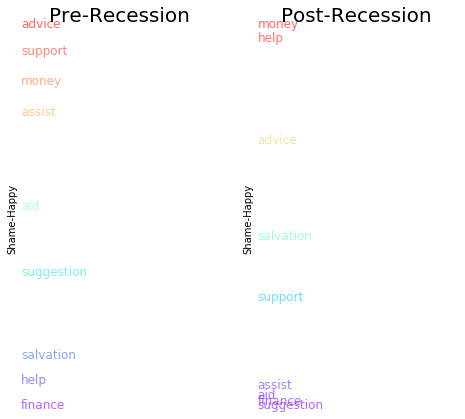

In [425]:
fig = plt.figure(figsize = (12,7))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, pre_HappyShameDF, 'Pre-Recession', 'Shame-Happy')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, post_HappyShameDF, 'Post-Recession', 'Shame-Happy')
plt.show()

Hypothesis 5: Society is looking for individual leadership that would bring them out of the predicament and collective cooperation was devalued.

In order to validate this hypothesis, I decided to create an emtional dimension in a scale of favor and dislike. Then I would throw in a list of nouns representing person with power.

In [341]:
pre_FavorHate = dimension(preW2V,
                         ['like', 'favor', 'prefer', 'worship', 'praise', 'acclaim'],
                         ['hate', 'stupid', 'averse', 'contempt', 'disdain'])
post_FavorHate = dimension(postW2V,
                         ['like', 'favor', 'prefer', 'worship', 'praise', 'acclaim'],
                         ['hate', 'stupid', 'averse', 'contempt', 'disdain'])

In [422]:
character = ['president', 'savior', 'leader', 
              'leader', 'captain', 'hero', 'boss', 'country']
together = ['collaboration', 'together', 'collective', 
            'communicate', 'team', 'teamwork']
yesorno = character + together

In [423]:
pre_FavorHateDF = makeDF(preW2V, yesorno, pre_FavorHate, 'Pre-Recession')
post_FavorHateDF = makeDF(postW2V, yesorno, post_FavorHate, 'Post-Recession')

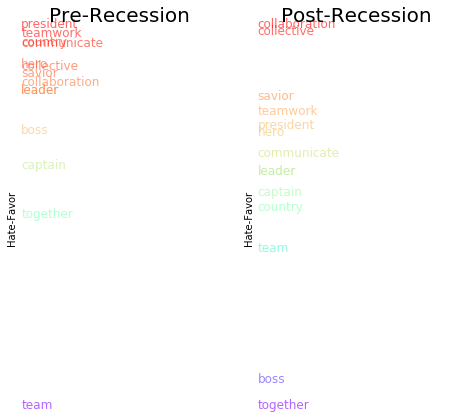

In [426]:
fig = plt.figure(figsize = (12,7))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, pre_FavorHateDF, 'Pre-Recession', 'Hate-Favor')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, post_FavorHateDF, 'Post-Recession', 'Hate-Favor')
plt.show()

Hypothesis 7: Hollywood portrays a positive image of the independent working woman both on and off screen

In order to validate this hypothesis, I decided to create an dimension of age. And reprocess the raw text.

In [347]:
stopwords = list(set(lucem_illud.stop_words_basic) - set(['he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself']))

In [348]:
#Apply our functions, notice each row is a list of lists now
preDF['tokenized_sents'] = preDF['plot'].apply(lambda x: 
                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
preDF['normalized_sents'] = preDF['tokenized_sents'].apply(lambda x: 
                                                           [lucem_illud.normalizeTokens(s, 
                                                                                        stopwordLst = stopwords, 
                                                                                        stemmer = None) 
                                                            for s in x])
#Apply our functions, notice each row is a list of lists now
postDF['tokenized_sents'] = postDF['plot'].apply(lambda x: 
                                               [nltk.word_tokenize(s) for s in nltk.sent_tokenize(x)])
postDF['normalized_sents'] = postDF['tokenized_sents'].apply(lambda x: 
                                                           [lucem_illud.normalizeTokens(s, 
                                                                                        stopwordLst = stopwords, 
                                                                                        stemmer = None) 
                                                            for s in x])
preW2V_gender = gensim.models.word2vec.Word2Vec(preDF['normalized_sents'].sum())
postW2V_gender = gensim.models.word2vec.Word2Vec(postDF['normalized_sents'].sum())

In [405]:
pre_Gender = dimension(preW2V_gender, ['man','him','he'], ['woman', 'her', 'she'])
post_Gender = dimension(postW2V_gender, ['man','him','he'], ['woman', 'her', 'she'])

In [409]:
work = ['independent', 'working', 'job', 'salary', 'position', 'office', 'meeting', 'interview', 'business', 'contract']

In [410]:
pre_GenderDF = makeDF(preW2V_gender, work, pre_Gender, 'Pre-Recession')
post_GenderDF = makeDF(postW2V_gender, work, pre_Gender, 'Post-Recession')

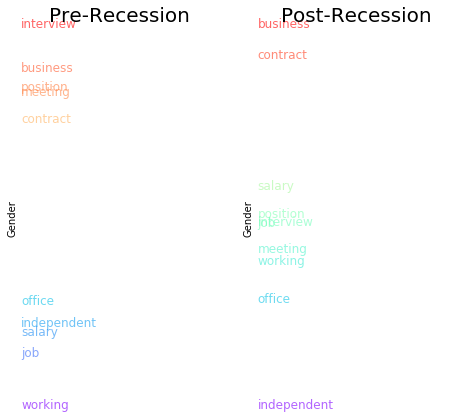

In [411]:
fig = plt.figure(figsize = (12,7))
ax1 = fig.add_subplot(131)
PlotDimension(ax1, pre_GenderDF, 'Pre-Recession', 'Gender')
ax2 = fig.add_subplot(132)
PlotDimension(ax2, post_GenderDF, 'Post-Recession', 'Gender')
plt.show()